In [16]:
############ example for a Alphalens tear sheet similar to
############ https://www.quantopian.com/tutorials/getting-started#lesson4
############ just works with zipline instead with quantopian.pipeline

from zipline.api import symbol

import zipline.algorithm as algo

import alphalens as al

from zipline.data import bundles

from zipline.data.data_portal import DataPortal

from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume, Returns, RSI, SimpleMovingAverage
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.filters import StaticAssets

from zipline.utils.calendars import get_calendar

from zipline.utils.run_algo import load_extensions

import numpy as np
import pandas as pd


#### need this to be able to access a custom bundle, would be nice if this would be included into zipline library one day
# Load extensions.py; this allows you access to custom bundles
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

####### get_pricing is missing

def get_pricing(trading_calendar, assets, start_date, end_date, field='close'):
    # Set the given start and end dates to Timestamps. The frequency string C is used to
    # indicate that a CustomBusinessDay DateOffset is used
    end_dt = pd.Timestamp(end_date, tz='UTC', freq='C')
    start_dt = pd.Timestamp(start_date, tz='UTC', freq='C')

    # Get the locations of the start and end dates
    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)
    
    data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar = trading_calendar,
                         first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
                         equity_daily_reader = bundle_data.equity_daily_bar_reader,
                         adjustment_reader = bundle_data.adjustment_reader)

    # return the historical data for the given window
    return data_portal.get_history_window(assets=assets, end_dt=end_dt, bar_count=end_loc - start_loc,
                                          frequency='1d',
                                          field=field,
                                          data_frequency='daily')
########################## done


bundle_data = bundles.load('sec_master_q')
# Set the trading calendar
trading_calendar = get_calendar('NYSE')




#################################

# Create a Pipeline engine ....... why can't i use just use
# this: factors = PipelineEngine.run_pipeline(initialize(universe),start_date=start_date,end_date=end_date) ?????

# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader)

# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# Create a Pipeline engine
engine = SimplePipelineEngine(get_loader = choose_loader,
                              calendar = trading_calendar.all_sessions,
                              asset_finder = bundle_data.asset_finder)


###########################################



# Create a screen for our Pipeline
universe = AverageDollarVolume(window_length = 60).top(1500)
# or single assets
#assets = bundle_data.asset_finder.lookup_symbols(['AAPL', 'MSFT'], as_of_date=None)
#sids = pd.Int64Index([asset.sid for asset in assets])


# Set the start and end dates
start_date = pd.Timestamp('2011-01-05', tz = 'utc')
end_date = pd.Timestamp('2017-02-01', tz = 'utc')



def make_pipeline(universe):

    # Momentum Factor Example
    momentum = Returns(inputs=[USEquityPricing.close], 
                        window_length=125,
                        mask=universe)

    last_close = USEquityPricing.close.latest
    
    SMA_200 = SimpleMovingAverage(inputs=[USEquityPricing.close],window_length=250,mask=universe)
    
    SMA_200_long = (last_close > SMA_200)
    
    SMA_200_short = (last_close < SMA_200)
    

    RSI_4 = RSI(inputs=[USEquityPricing.close],window_length=4,mask=universe)
    
    RSI_long = (RSI_4 < 20)
    
    RSI_short = (RSI_4 > 80)
    
    long = SMA_200_long & RSI_long & momentum.top(20)
    
    short = SMA_200_short & RSI_short & momentum.bottom(20)
    
    top_bottom_scores = ( long | short )
         
    return Pipeline(columns={
                              'MyFactor': momentum,
                              'longs': long,
                              'shorts': short,
                          }, screen=(universe & top_bottom_scores) )



# Execute pipeline over evaluation period

factors = engine.run_pipeline(make_pipeline(universe),start_date=start_date,end_date=end_date)
#factors = PipelineEngine.run_pipeline(initialize(universe),start_date=start_date,end_date=end_date)

factors = factors.dropna()

asset_list = factors.index.levels[1].unique()

prices = get_pricing(trading_calendar, asset_list, start_date=start_date, end_date=end_date )

Dropped 10.2% entries from factor data: 9.6% in forward returns computation and 0.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


min        max      mean       std  count    count %
factor_quantile                                                           
1.0             -1.000000   2.274194 -0.341406  0.579611   2520  25.674987
2.0             -0.851240   2.075285 -0.038475  0.712761   1656  16.872134
3.0             -0.784242   2.749801  0.253893  0.838775   1705  17.371370
4.0             -0.776637   4.095715  0.585354  0.943866   1650  16.811004
5.0             -0.711179  10.167247  1.604197  1.620206   2284  23.270504

Returns Analysis


1D     5D     10D     20D  \
Ann. alpha                                      0.087  0.038   0.095   0.134   
beta                                           -0.150 -0.144  -0.055  -0.016   
Mean Period Wise Return Top Quantile (bps)     -0.317 -1.080   2.942   2.664   
Mean Period Wise Return Bottom Quantile (bps) -10.608 -9.005  -9.482  -7.325   
Mean Period Wise Spread (bps)                  10.291  7.913  12.516  10.363   

                                                  40D     80D  
Ann. alpha                                      0.149   0.148  
beta                                           -0.033   0.013  
Mean Period Wise Return Top Quantile (bps)      3.886   4.169  
Mean Period Wise Return Bottom Quantile (bps)  -7.964  -7.902  
Mean Period Wise Spread (bps)                  12.298  12.506

/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/pandas/core/indexes/datetimes.py:840: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)
/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/alphalens/performance.py:455: RuntimeWarning: invalid value encountered in double_scalars
  return ((np.nansum(ret) + 1)**(1. / period)) - 1


<Figure size 432x288 with 0 Axes>

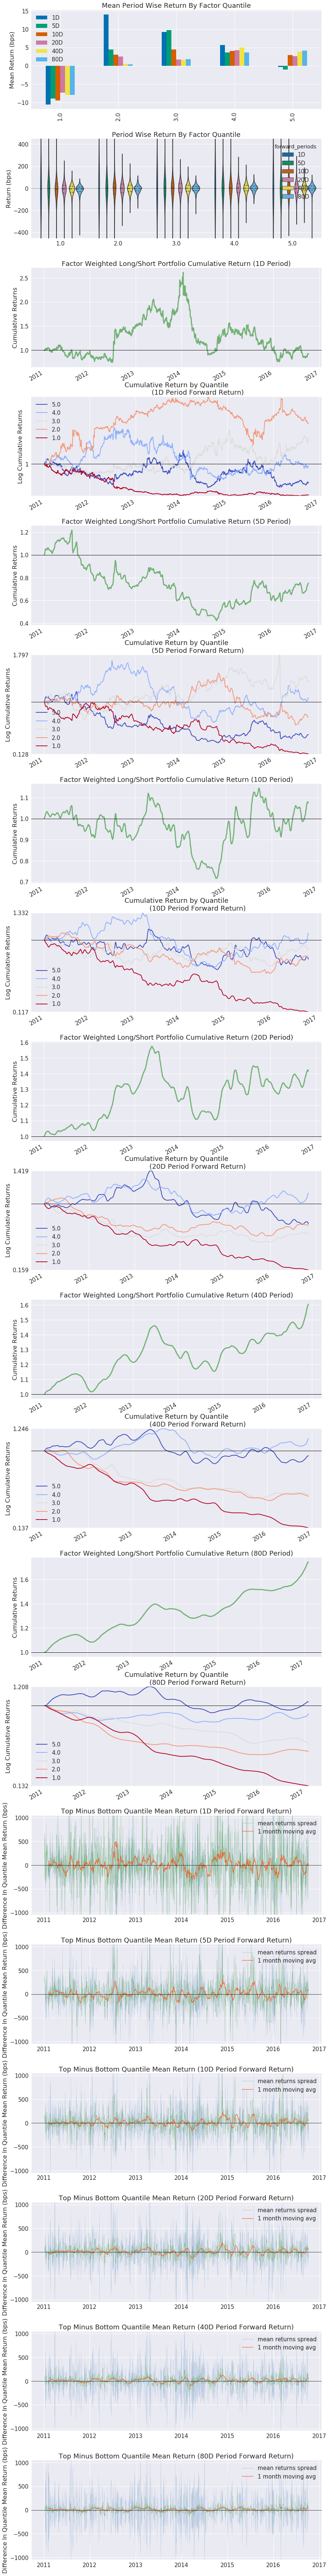

/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Information Analysis


1D     5D    10D    20D    40D    80D
IC Mean           0.013 -0.013  0.007  0.013  0.044  0.088
IC Std.           0.535  0.536  0.538  0.544  0.544  0.533
Risk-Adjusted IC  0.024 -0.024  0.013  0.024  0.081  0.165
t-stat(IC)        0.903    NaN  0.497  0.908  3.002  6.126
p-value(IC)       0.366    NaN  0.619  0.364  0.003  0.000
IC Skew          -0.030    NaN -0.036 -0.014 -0.128 -0.158
IC Kurtosis      -0.714    NaN -0.743 -0.776 -0.783 -0.680

/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/Users/carstenfreek/opt/anaconda3/envs/test35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg wa

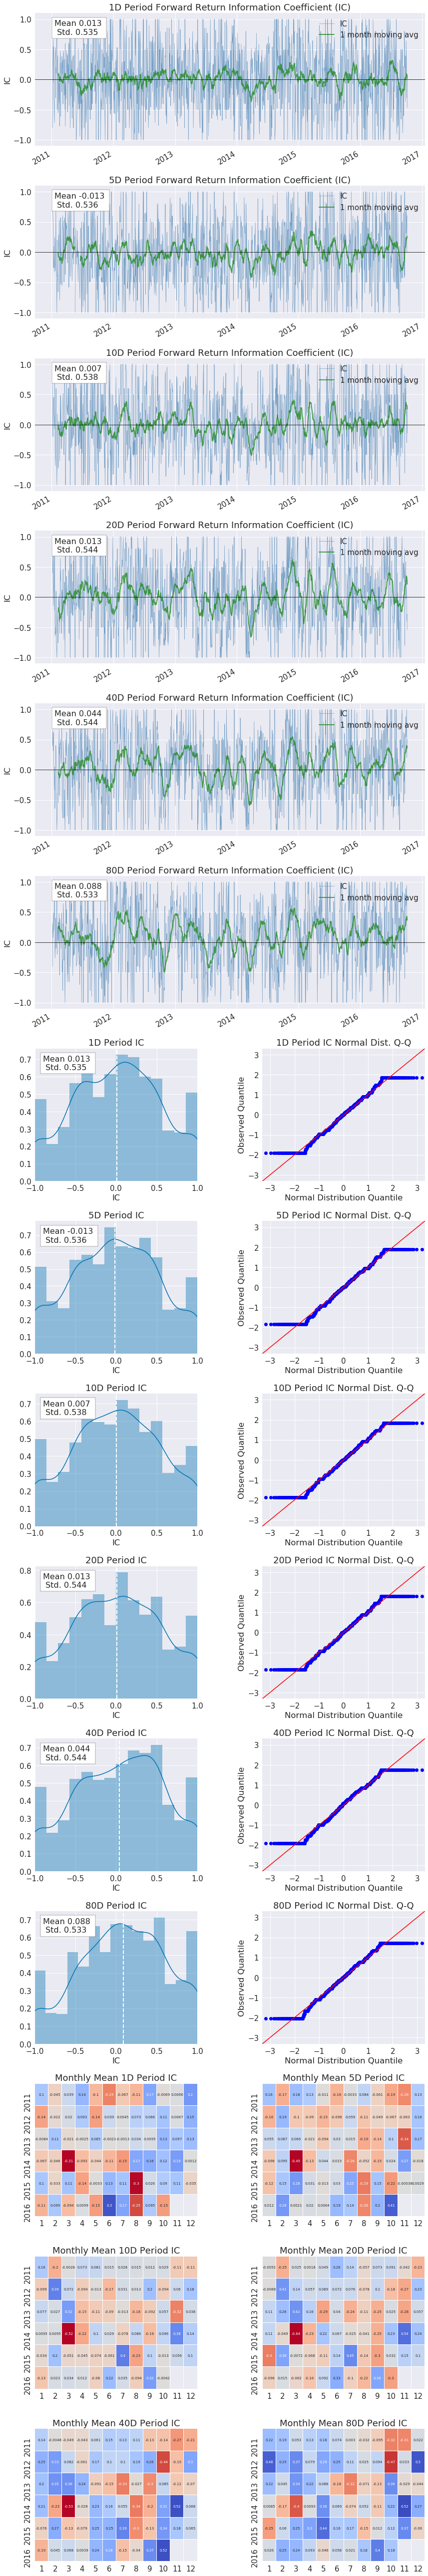

Turnover Analysis


10D     1D    20D    40D     5D    80D
Quantile 1 Mean Turnover   0.903  0.638  0.916  0.955  0.890  0.977
Quantile 2 Mean Turnover   0.954  0.796  0.971  0.973  0.962  0.994
Quantile 3 Mean Turnover   0.967  0.825  0.971  0.991  0.963  0.991
Quantile 4 Mean Turnover   0.969  0.829  0.981  0.983  0.961  0.994
Quantile 5 Mean Turnover   0.887  0.649  0.918  0.953  0.883  0.987

1D   5D    10D   20D    40D    80D
Mean Factor Rank Autocorrelation  0.921  0.8  0.733  0.65  0.386  0.134

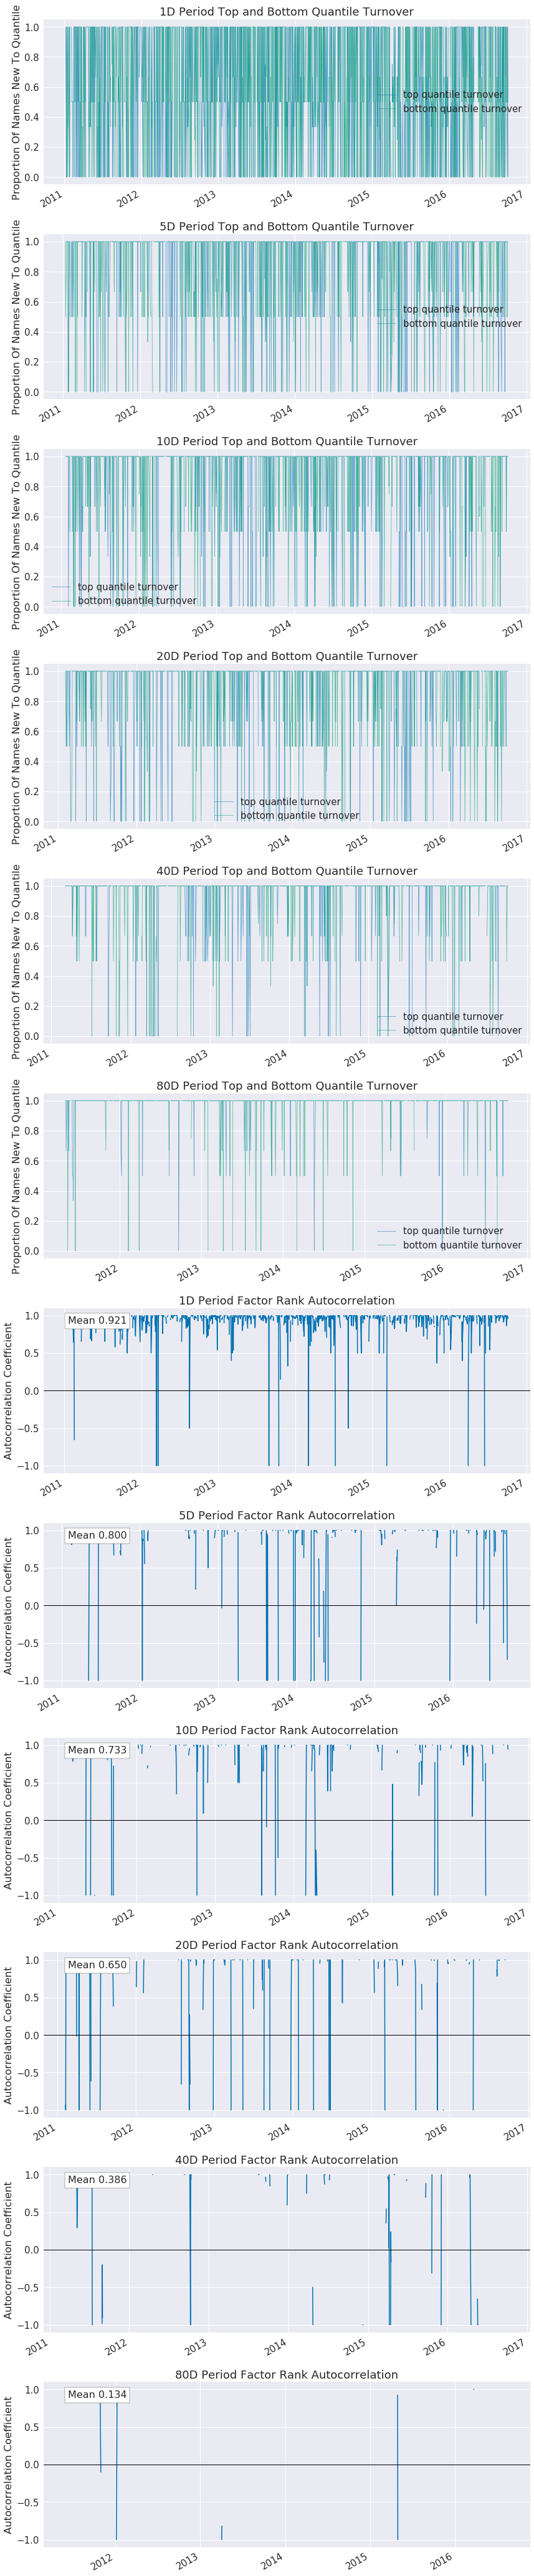

In [17]:
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=factors["MyFactor"],
    prices=prices,
    quantiles=5,
#    quantiles=None,
#    bins=2,
    periods=(1,5,10,20,40,80))

al.tears.create_full_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=False)